# Reducing model size

In this experiment, we look at the effects of reducing the size of the model.

In [45]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class GameOfLifeDataset(torch.utils.data.Dataset):
    _size = 512

    def __init__(self):
        pass

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        # 12 -> "0b1100" -> "1100" -> "000001100"
        idx_bin = bin(idx)[2:].rjust(9, "0")
        X = torch.tensor([float(ch) for ch in idx_bin], dtype=torch.float32).reshape(1, 3, 3) # (channels, width, height)
        alive = X[0, 1, 1] > 0.5
        alive_neighbours = torch.sum(X) - X[0, 1, 1]
        next_alive = (alive and alive_neighbours > 1.5 and alive_neighbours < 3.5) or (not alive and alive_neighbours > 2.5 and alive_neighbours < 3.5)
        y = torch.tensor([float(next_alive)], dtype=torch.float32).reshape(1, 1) # (width, height)
        return X, y

In [4]:
dataset = GameOfLifeDataset()
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
class CellPredictorNeuralNetwork(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of shape (batch_size, channels, width+2, height+2), where channels=1. width and height are the dimensions of the entire game grid.
           We add one cell of padding on each side to ensure that predictions can be made for the boundary cells.
    
    Returns: Tensor of shape (batch_size, width, height), the logits of the predicted states.
    """

    def __init__(self, conv0_channels=85):
        super().__init__()
        self.conv0 = nn.Conv2d(1, conv0_channels, 3)
        self.conv1 = nn.Conv2d(conv0_channels, 10, 1)
        self.conv2 = nn.Conv2d(10, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        logits = self.conv2(x)
        logits = torch.squeeze(logits, 1) # Remove channels dimension
        return logits

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            prob = F.sigmoid(pred)
            correct += ((prob > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return {
        "loss": test_loss,
        "acc": correct
    }

In [28]:
learning_rate = 1e-1
batch_size = 4
epochs = 20

conv0_channels: 85
Training model...
Done!
conv0_channels: 10
Training model...
Done!
conv0_channels: 5
Training model...
Done!
conv0_channels: 2
Training model...
Done!
conv0_channels: 1
Training model...
Done!


[]

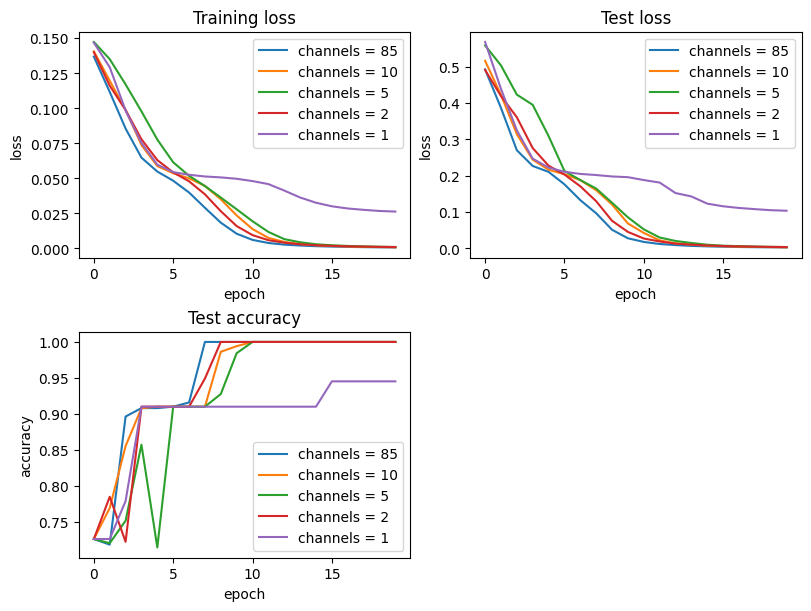

In [46]:
conv0_channels_list = [85, 10, 5, 2, 1]

fig, axs = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss, ax_test_loss, ax_test_acc, ax_blank = axs

ax_loss.set_title("Training loss")
ax_loss.set_xlabel("epoch")
ax_loss.set_ylabel("loss")

ax_test_loss.set_title("Test loss")
ax_test_loss.set_xlabel("epoch")
ax_test_loss.set_ylabel("loss")

ax_test_acc.set_title("Test accuracy")
ax_test_acc.set_xlabel("epoch")
ax_test_acc.set_ylabel("accuracy")

ax_blank.axis("off")

for conv0_channels in conv0_channels_list:
    print(f"conv0_channels: {conv0_channels}")
    model = CellPredictorNeuralNetwork(conv0_channels).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print("Training model...")
    for t in range(epochs):
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(dataloader, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])

    print("Done!")

    ax_loss.plot(loss_history, label=f"channels = {conv0_channels}")
    ax_test_loss.plot(test_loss_history, label=f"channels = {conv0_channels}")
    ax_test_acc.plot(test_acc_history, label=f"channels = {conv0_channels}")
    
    
ax_loss.legend()
ax_test_loss.legend()
ax_test_acc.legend()
plt.show()

The plot above clearly shows that we can get away with much fewer than 85 channels in the `conv0` layer. The graphs are very similar between 85 and 10 channels, so we can reduce to 10 channels without noticeable loss in performance. The main difference is that the model takes a little longer to train with 10 channels.

At the other extreme, having only one channel in the `conv0` layer is severely detrimental and the model barely learns anything.

With 5 channels, the model starts to learn noticeably more slowly and there is some instability in the training process.

With 2 channels, the model sometimes fails to learn effectively, and sometimes learns even faster than with 10 channels. I suspect that the surprising benefit of having 2 channels comes from the fact that the Game of Life update rule can be expressed cleanly in terms of two low-level concepts: whether the middle cell is alive, and the count of alive neighbours. We can test this hypothesis by visualizing the `conv0` features.

In [62]:
def train_and_visualize(conv0_channels):
    if conv0_channels > 18:
        raise ValueError("Too many channels to visualize.")

    fig, axs = plt.subplots(1, 2, figsize=(8, 6), constrained_layout=True)
    axs = axs.flatten()
    ax_loss, ax_acc = axs

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("epoch")
    ax_loss.set_ylabel("loss")

    ax_acc.set_title("Accuracy")
    ax_acc.set_xlabel("epoch")
    ax_acc.set_ylabel("accuracy")

    print(f"conv0_channels: {conv0_channels}")
    model = CellPredictorNeuralNetwork(conv0_channels).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_acc_history = []

    print("Training model...")
    for t in range(epochs):
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(dataloader, model, loss_fn)
        test_acc_history.append(test_metrics["acc"])

    print("Done!")

    ax_loss.plot(loss_history, label=f"channels = {conv0_channels}")
    ax_acc.plot(test_acc_history, label=f"channels = {conv0_channels}")
    
    ax_loss.legend()
    ax_acc.legend()
    plt.show()

    with torch.no_grad():
        feature_viz = model.conv0.weight[:, 0, :, :]
        feature_viz = feature_viz.numpy().copy()

    fig, axs = plt.subplots(3, 6, constrained_layout=True, figsize=(10, 5))
    axs = axs.flatten()

    for feature in range(18):
        ax: plt.Axes = axs[feature]

        if feature >= conv0_channels:
            ax.set_visible(False)
            continue

        pos = ax.imshow(feature_viz[feature], interpolation="nearest", vmin=-1.0, vmax=1.0)
        fig.colorbar(pos, ax=ax)
        ax.set_title(f"Feature {feature}")

    plt.show()

conv0_channels: 10
Training model...
Done!


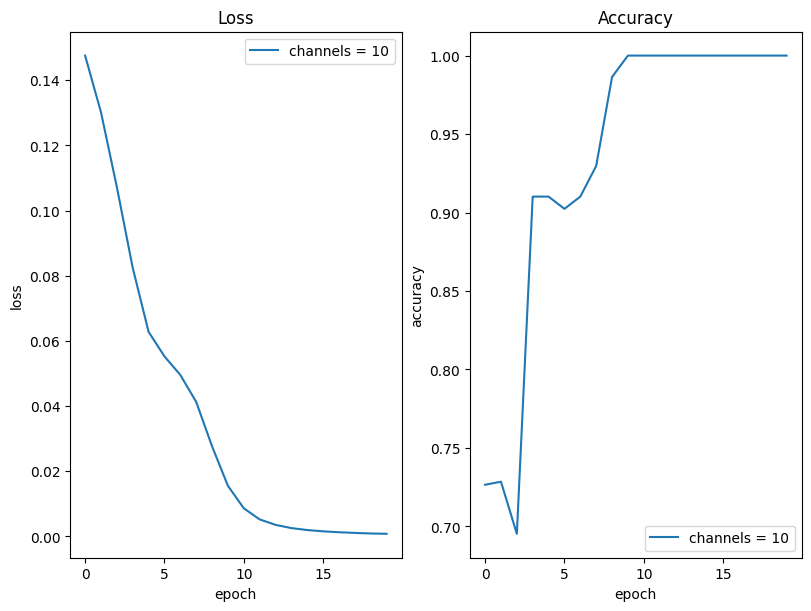

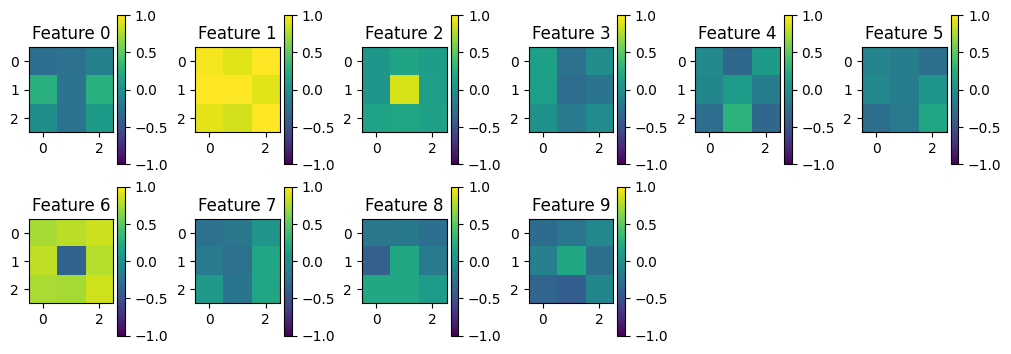

In [63]:
train_and_visualize(10)

From these feature visualizations, it looks like the model is learning more meaningful features with 10 `conv0` channels than with 85 channels. The number of alive neighbours can be clearly seen in feature 6. The concept of the middle cell being alive can be seen most clearly in feature 2. Feature 1 counts the total number of alive cells, so can be used to translate between the "middle cell alive" and "number of alive neighbours" concepts.

conv0_channels: 5
Training model...
Done!


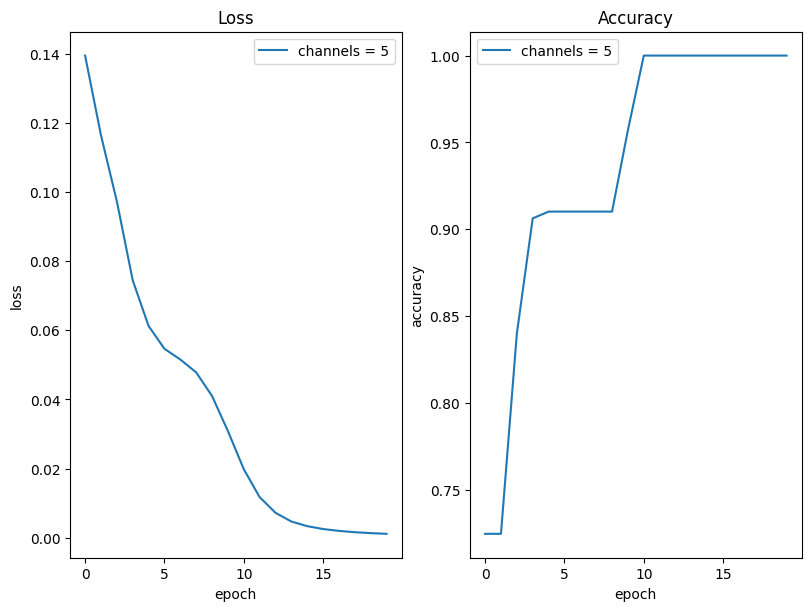

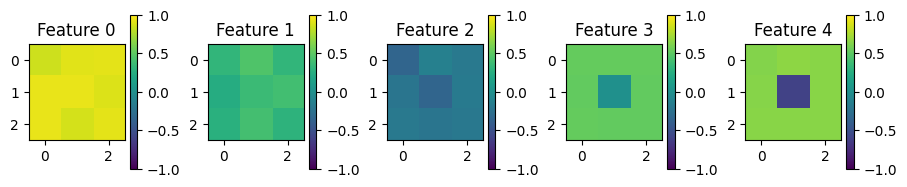

In [64]:
train_and_visualize(5)

With 5 `conv0` features, we see "number of alive neighbours" in feature 3, "total number of alive cells" in feature 0 and "number of alive neighbours, minus one if the middle cell is alive" in feature 4.

conv0_channels: 2
Training model...
Done!


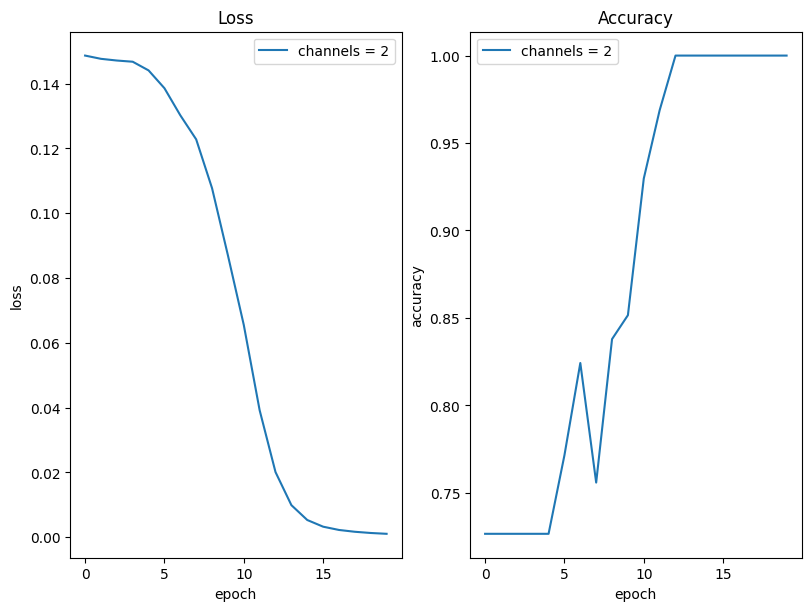

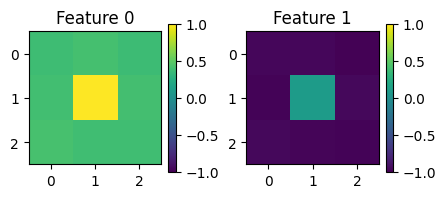

In [65]:
train_and_visualize(2)

Here it's fairly clear. One feature is testing whether the middle cell is alive and the other is counting the number of alive neighbours. The exact meaning of the filters depends on the biases.

conv0_channels: 1
Training model...
Done!


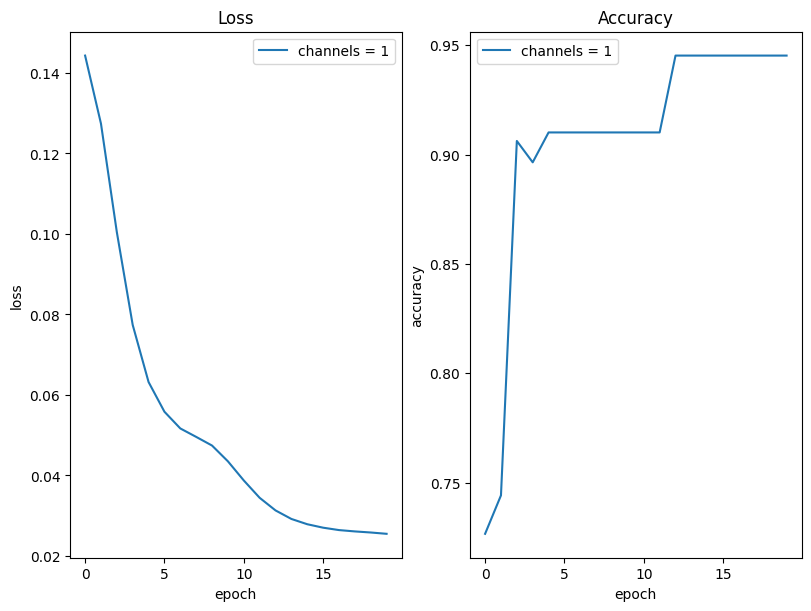

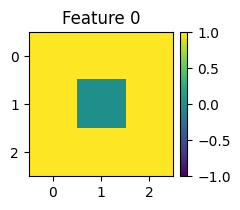

In [66]:
train_and_visualize(1)

Though we don't reach 100% accuracy with one `conv0` feature, it's clear that it is picking out the number of alive neighbours as a meaningful feature.

# Conclusion

In summary, we can safely reduce the number of `conv0` features in the neural network down to 10. It is reasonable to assume this will improve inference time (not that it particularly needs improving at this point), and it seems to force the model to learn more meaningful features, perhaps because there are fewer ways for these concepts to be expressed as a combination of many features.

Reducing the number of `conv0` features significantly below 10, while keeping the rest of the architecture constant, seems to slow down the training process and increase instability.

# Addendum

While the models with 10 and 85 `conv0` features both achieve 100% accuracy on the dataset, their behaviours in probabilistic mode and soft mode differ significantly.

In probabilistic mode, the 85-feature model occasionally transitions a cell incorrectly, which upsets the delicate balance of the Gosper Glider Gun. From then on, the cells tend to die out, and the result is an entirely dead grid with isolated cells regularly flickering to life and dying out immediately afterwards. The 10-feature model makes a lot more mistakes, and the grid ends up teeming with life, but in a very chaotic way.

In soft mode, the 85-feature model keeps all cells very close to 0 or 1. Cells essentially never go much above 1.0e-14 or below 0.998. The process seems very stable, even when run for 10 minutes. Values do not degrade to 0.5 - indeed the values often get pushed even closer to 0 or 1 than they already are, such as 1.0e-14 values spontaneously going as low as 1.0e-21. In contrast, the 10-feature model is not very disciplined with keeping values near 0 or 1. The neat order quickly degrades to a chaotic soup of somewhat-life and somewhat-death. Even spaces that start uniformly dead are quickly pushed to uniformly mostly-dead, seen in the faint silhouettes of cells across the entire grid.

The difference in behaviour might be because the 10-feature model was slower to train than the 85-feature model and both were trained for 20 epochs, so the 85-feature model likely attained a much lower loss in those 20 epochs.

Additionally, since neither model was trained on a dataset that included random perturbations, there may be something about having more features that makes the model automatically more robust against noise without explicitly being trained for it.